<a href="https://colab.research.google.com/github/florvil1066/CAP3321C-Final-Project/blob/main/CAP3321CFinalExam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1:  Install and Import all Libraries

In [1]:
# Install libraries
!pip install xgboost lightgbm catboost -qqq
!pip install census -qqq
!pip install us


import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import os
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor, BaggingRegressor, VotingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import (LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
                              HistGradientBoostingClassifier, BaggingClassifier, VotingClassifier, StackingClassifier)
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import spearmanr
import time, os, joblib
from census import Census
from us import states

In [2]:
# ---------- CONFIG ----------
RANDOM_STATE = 1
N_SPLITS = 10
TOP_K = 10
# ----------------------------

# Step 2: Load the Dataset

In [3]:
# Load the dataset
from google.colab import files
uploaded = files.upload()

Saving Superstore_CAP.csv to Superstore_CAP (1).csv


In [4]:
# Read the data
super_df = pd.read_csv(list(uploaded.keys())[0])

In [5]:
!ls /content/

 catboost_info	 sample_data  'Superstore_CAP (1).csv'	 Superstore_CAP.csv


In [6]:
# preview the dataset
# Display the data
super_df.info()
print(super_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row_ID         9994 non-null   int64  
 1   Order_ID       9994 non-null   object 
 2   Order_Date     9994 non-null   object 
 3   Ship_Date      9994 non-null   object 
 4   Ship_Mode      9994 non-null   object 
 5   Customer_ID    9994 non-null   object 
 6   Customer_Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal_Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product_ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product_Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [7]:
super_df.head(6)

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,...,Product_ID,Category,Sub-Category,Product_Name,Sales,Quantity,Discount,Profit,Returned,Order ID
0,1,CA-2013-152156,11/7/2021,11/10/2021,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,Yes,CA-2014-153822
1,2,CA-2013-152156,11/7/2021,11/10/2021,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,Yes,CA-2014-129707
2,3,CA-2013-138688,6/11/2021,6/15/2021,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,Yes,CA-2011-152345
3,4,US-2012-108966,10/9/2020,10/16/2020,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,Yes,CA-2012-156440
4,5,US-2012-108966,10/9/2020,10/16/2020,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,Yes,US-2014-155999
5,6,CA-2011-115812,6/7/2019,6/12/2019,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694,Yes,CA-2011-157924


Step 3: Data Cleaning and Preprocessing

In [8]:
def analyze_columns_for_encoding(super_df, threshold=50):
    """
    Analyzes the dataframe columns, checking the number of unique values
    and recommending which columns should be dropped, kept, or treated
    before using get_dummies for encoding to avoid dimensionality issues.

    Parameters:
    df : pandas.DataFrame
        The dataframe to analyze.
    threshold : int
        The maximum number of unique values in a column to recommend encoding.

    Returns:
    report : pandas.DataFrame
        A report with recommendations for each column.
    """
    # Create an empty DataFrame for the report
    report = pd.DataFrame(columns=['Column', 'Data Type', 'Unique Values', 'Recommendation'])

    for column in super_df.columns: # Changed heart_df to sales_df to match the parameter name
        unique_values = super_df[column].nunique() # Changed heart_df to sales_df
        data_type = super_df[column].dtype # Changed heart_df to sales_df

        # Determine the recommendation based on unique values and data type
        if data_type == 'object' or data_type == 'category':
            if unique_values > threshold:
                recommendation = "Consider Dropping or Encoding Differently (Too many categories)"
            elif unique_values == 2:
                recommendation = "Keep (Binary category)"
            else:
                recommendation = "Keep but beware of dimensionality (Low unique categories)"
        elif data_type in ['int64', 'float64']:
            if unique_values == 2:
                recommendation = "Keep (Binary numeric)"
            else:
                recommendation = "Keep (Continuous)"
        else:
            recommendation = "Consider Dropping (Unknown data type)"

        # Create a new row with the column analysis
        new_row = pd.DataFrame({
            'Column': [column],
            'Data Type': [data_type],
            'Unique Values': [unique_values],
            'Recommendation': [recommendation]
        })

        # Concatenate the new row to the report DataFrame
        report = pd.concat([report, new_row], ignore_index=True)

    return report

# Set your threshold for handling categorical variables
threshold_value = 50

# Analyze the dataframe columns
report = analyze_columns_for_encoding(super_df, threshold=threshold_value) # Changed heart_df to sales_df

# Display the report
report

,Column,Data Type,Unique Values,Recommendation
0,Row_ID,int64,9994,Keep (Continuous)
1,Order_ID,object,5009,Consider Dropping or Encoding Differently (Too...
2,Order_Date,object,1238,Consider Dropping or Encoding Differently (Too...
3,Ship_Date,object,1334,Consider Dropping or Encoding Differently (Too...
4,Ship_Mode,object,4,Keep but beware of dimensionality (Low unique ...
5,Customer_ID,object,793,Consider Dropping or Encoding Differently (Too...
6,Customer_Name,object,793,Consider Dropping or Encoding Differently (Too...
7,Segment,object,3,Keep but beware of dimensionality (Low unique ...
8,Country,object,1,Keep but beware of dimensionality (Low unique ...
9,City,object,531,Consider Dropping or Encoding Differently (Too...


In [9]:
# Create an empty list called regression_models
regression_models = []

# Instantiate base regressors for Voting and Stacking
base_regressors = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(random_state=RANDOM_STATE)),
    ('svr', SVR())
]

# Instantiate several regression model objects and add them to the regression_models list
regression_models.append(LinearRegression())
regression_models.append(Ridge(random_state=RANDOM_STATE))
regression_models.append(Lasso(random_state=RANDOM_STATE))
regression_models.append(ElasticNet(random_state=RANDOM_STATE))
regression_models.append(KNeighborsRegressor())
regression_models.append(DecisionTreeRegressor(random_state=RANDOM_STATE))
regression_models.append(RandomForestRegressor(random_state=RANDOM_STATE))
regression_models.append(GradientBoostingRegressor(random_state=RANDOM_STATE))
regression_models.append(AdaBoostRegressor(random_state=RANDOM_STATE))
regression_models.append(HistGradientBoostingRegressor(random_state=RANDOM_STATE))
regression_models.append(BaggingRegressor(random_state=RANDOM_STATE))
regression_models.append(VotingRegressor(estimators=base_regressors))
regression_models.append(StackingRegressor(estimators=base_regressors))
regression_models.append(MLPRegressor(random_state=RANDOM_STATE, max_iter=1000))
regression_models.append(GaussianProcessRegressor(random_state=RANDOM_STATE))
regression_models.append(SVR())
regression_models.append(LinearSVR(random_state=RANDOM_STATE, dual=True))

print("Regression models defined:")
for model in regression_models:
    print(type(model).__name__)

Regression models defined:
LinearRegression
Ridge
Lasso
ElasticNet
KNeighborsRegressor
DecisionTreeRegressor
RandomForestRegressor
GradientBoostingRegressor
AdaBoostRegressor
HistGradientBoostingRegressor
BaggingRegressor
VotingRegressor
StackingRegressor
MLPRegressor
GaussianProcessRegressor
SVR
LinearSVR


Validate Data Types and Inspect the Dataset Structure

In [10]:
super_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row_ID         9994 non-null   int64  
 1   Order_ID       9994 non-null   object 
 2   Order_Date     9994 non-null   object 
 3   Ship_Date      9994 non-null   object 
 4   Ship_Mode      9994 non-null   object 
 5   Customer_ID    9994 non-null   object 
 6   Customer_Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal_Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product_ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product_Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [11]:
# Scale the data
scaler = StandardScaler()

# Select only numerical columns for scaling
numerical_cols = super_df.select_dtypes(include=np.number).columns.tolist()
# Exclude the target column 'Profit' from scaling
if 'Profit' in numerical_cols:
    numerical_cols.remove('Profit')

scaled_features = scaler.fit_transform(super_df[numerical_cols])
X = pd.DataFrame(scaled_features, columns=numerical_cols)
y = super_df['Profit']

Train and Split the data

In [12]:
# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print("Data splitting complete:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data splitting complete:
X_train shape: (7995, 5)
X_test shape: (1999, 5)
y_train shape: (7995,)
y_test shape: (1999,)


In [13]:
# Create a DataFrame to store the performance metrics
regression_results_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'R2'])

# Re-iterate through each regression model to populate the DataFrame
for model in regression_models:
    model_name = type(model).__name__

    try:
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Append the results to the DataFrame
        new_row = pd.DataFrame({'Model': [model_name], 'MAE': [mae], 'MSE': [mse], 'R2': [r2]})
        #regression_results_df = pd.concat([regression_results_df, new_row], ignore_index=True)

    except Exception as e:
        print(f"Could not get metrics for {model_name}: {e}")


# Sort the DataFrame by R-squared score in descending order
regression_results_df = regression_results_df.sort_values(by='R2', ascending=False)

# Display the performance comparison
print("\n=== Regression Model Performance Comparison ===")
display(regression_results_df)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



=== Regression Model Performance Comparison ===


,Model,MAE,MSE,R2


In [14]:
# Create a DataFrame to store the performance metrics
regression_results_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'R2'])

# Re-iterate through each regression model to populate the DataFrame
for model in regression_models:
    model_name = type(model).__name__

    try:
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Append the results to the DataFrame
        new_row = pd.DataFrame({'Model': [model_name], 'MAE': [mae], 'MSE': [mse], 'R2': [r2]})
        regression_results_df = pd.concat([regression_results_df, new_row], ignore_index=True)

    except Exception as e:
        print(f"Could not get metrics for {model_name}: {e}")


# Sort the DataFrame by R-squared score in descending order
regression_results_df = regression_results_df.sort_values(by='R2', ascending=False)

# Display the performance comparison
print("\n=== Regression Model Performance Comparison ===")
display(regression_results_df)

/tmp/ipython-input-117241371.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_results_df = pd.concat([regression_results_df, new_row], ignore_index=True)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



=== Regression Model Performance Comparison ===


,Model,MAE,MSE,R2
4,KNeighborsRegressor,32.061511,1.098612e+04,0.655809
6,RandomForestRegressor,25.085469,1.179303e+04,0.630528
9,HistGradientBoostingRegressor,27.178645,1.230589e+04,0.614461
13,MLPRegressor,42.488902,1.351444e+04,0.576597
10,BaggingRegressor,26.645279,1.380884e+04,0.567374
11,VotingRegressor,35.685240,1.491488e+04,0.532722
12,StackingRegressor,32.345988,1.536285e+04,0.518687
8,AdaBoostRegressor,64.033396,1.714388e+04,0.462888
7,GradientBoostingRegressor,30.321228,1.738838e+04,0.455228
2,Lasso,53.308935,1.901968e+04,0.404120


In [15]:
# Instantiate PCA
# Retain 95% of variance or reduce to 100 components, whichever is smaller
pca = PCA(n_components=min(X_train.shape[1], 100), random_state=RANDOM_STATE)


# Fit PCA on the training data
pca.fit(X_train)

# Transform both training and testing data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Print the shape of the transformed data
print("Shape of transformed training data:", X_train_pca.shape)
print("Shape of transformed testing data:", X_test_pca.shape)

Shape of transformed training data: (7995, 5)
Shape of transformed testing data: (1999, 5)


In [16]:
# Create a DataFrame to store the performance metrics after PCA
regression_results_pca_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'R2'])

# Iterate through each regression model to make predictions and calculate metrics
for model in regression_models:
    model_name = type(model).__name__

    try:
        # Fit the model to the dimensionality-reduced training data
        model.fit(X_train_pca, y_train)

        # Make predictions on the dimensionality-reduced test data
        y_pred_pca = model.predict(X_test_pca)

        # Calculate evaluation metrics
        mae_pca = mean_absolute_error(y_test, y_pred_pca)
        mse_pca = mean_squared_error(y_test, y_pred_pca)
        r2_pca = r2_score(y_test, y_pred_pca)

        # Append the results to the DataFrame
        new_row_pca = pd.DataFrame({'Model': [model_name], 'MAE': [mae_pca], 'MSE': [mse_pca], 'R2': [r2_pca]})
        regression_results_pca_df = pd.concat([regression_results_pca_df, new_row_pca], ignore_index=True)

    except Exception as e:
        print(f"Could not get metrics for {model_name} after PCA: {e}")


# Sort the DataFrame by R-squared score in descending order
regression_results_pca_df = regression_results_pca_df.sort_values(by='R2', ascending=False)

# Display the performance comparison after PCA
print("\n=== Regression Model Performance Comparison (After PCA) ===")
display(regression_results_pca_df)

# Compare with previous results (assuming regression_results_df exists from before)
if 'regression_results_df' in locals():
    print("\n=== Performance Comparison (Before vs After PCA) ===")
    comparison_df = regression_results_df.merge(regression_results_pca_df, on='Model', suffixes=('_BeforePCA', '_AfterPCA'))
    comparison_df['R2_Change'] = comparison_df['R2_AfterPCA'] - comparison_df['R2_BeforePCA']
    comparison_df['MAE_Change'] = comparison_df['MAE_AfterPCA'] - comparison_df['MAE_BeforePCA']
    comparison_df['MSE_Change'] = comparison_df['MSE_AfterPCA'] - comparison_df['MSE_BeforePCA']

    display(comparison_df.sort_values(by='R2_Change', ascending=False))
else:
    print("\n'regression_results_df' not found. Cannot compare performance before and after PCA.")

/tmp/ipython-input-456604769.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_results_pca_df = pd.concat([regression_results_pca_df, new_row_pca], ignore_index=True)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



=== Regression Model Performance Comparison (After PCA) ===


,Model,MAE,MSE,R2
9,HistGradientBoostingRegressor,32.939610,1.090286e+04,0.658417
4,KNeighborsRegressor,32.061511,1.098612e+04,0.655809
13,MLPRegressor,42.063089,1.124433e+04,0.647719
6,RandomForestRegressor,29.451413,1.395544e+04,0.562781
11,VotingRegressor,37.401740,1.575952e+04,0.506259
7,GradientBoostingRegressor,41.777606,1.683247e+04,0.472644
10,BaggingRegressor,31.361512,1.710467e+04,0.464116
12,StackingRegressor,36.480362,1.825255e+04,0.428154
2,Lasso,53.205303,1.901752e+04,0.404187
0,LinearRegression,53.962251,1.903839e+04,0.403534



=== Performance Comparison (Before vs After PCA) ===


,Model,MAE_BeforePCA,MSE_BeforePCA,R2_BeforePCA,MAE_AfterPCA,MSE_AfterPCA,R2_AfterPCA,R2_Change,MAE_Change,MSE_Change
14,DecisionTreeRegressor,33.724667,2.702214e+04,0.153405,40.216139,2.418614e+04,0.242256,8.885090e-02,6.491472e+00,-2.835999e+03
3,MLPRegressor,42.488902,1.351444e+04,0.576597,42.063089,1.124433e+04,0.647719,7.112187e-02,-4.258130e-01,-2.270113e+03
2,HistGradientBoostingRegressor,27.178645,1.230589e+04,0.614461,32.939610,1.090286e+04,0.658417,4.395630e-02,5.760965e+00,-1.403025e+03
8,GradientBoostingRegressor,30.321228,1.738838e+04,0.455228,41.777606,1.683247e+04,0.472644,1.741647e-02,1.145638e+01,-5.559098e+02
16,GaussianProcessRegressor,1824.949192,8.854372e+07,-2773.045188,1824.955595,8.854361e+07,-2773.041832,3.356518e-03,6.403046e-03,-1.071354e+02
9,Lasso,53.308935,1.901968e+04,0.404120,53.205303,1.901752e+04,0.404187,6.762125e-05,-1.036321e-01,-2.158377e+00
0,KNeighborsRegressor,32.061511,1.098612e+04,0.655809,32.061511,1.098612e+04,0.655809,0.000000e+00,0.000000e+00,0.000000e+00
10,LinearRegression,53.962251,1.903839e+04,0.403534,53.962251,1.903839e+04,0.403534,-1.110223e-16,-2.131628e-14,3.637979e-12
11,Ridge,53.958861,1.903845e+04,0.403532,53.958861,1.903845e+04,0.403532,-2.220446e-16,2.131628e-14,7.275958e-12
15,SVR,42.578218,2.938472e+04,0.079387,42.578203,2.938474e+04,0.079386,-5.765559e-07,-1.473340e-05,1.840287e-02


In [17]:
# Merge the two dataframes to create the comparison_df
comparison_df = regression_results_df.merge(regression_results_pca_df, on='Model', suffixes=('_BeforePCA', '_AfterPCA'))

# Calculate the change in R2, MAE, and MSE
comparison_df['R2_Change'] = comparison_df['R2_AfterPCA'] - comparison_df['R2_BeforePCA']
comparison_df['MAE_Change'] = comparison_df['MAE_AfterPCA'] - comparison_df['MAE_BeforePCA']
comparison_df['MSE_Change'] = comparison_df['MSE_AfterPCA'] - comparison_df['MSE_BeforePCA']

# Create the mae_mse_comparison DataFrame
mae_mse_comparison = comparison_df[['Model', 'MAE_BeforePCA', 'MSE_BeforePCA', 'MAE_AfterPCA', 'MSE_AfterPCA', 'MAE_Change', 'MSE_Change']].copy()

# Display the comparison DataFrames
print("\n=== Performance Comparison (Before vs After PCA) ===")
display(comparison_df.sort_values(by='R2_Change', ascending=False))

print("\n=== MAE and MSE Comparison (Before vs After PCA) ===")
display(mae_mse_comparison.sort_values(by='MAE_Change', ascending=True))

print("\nGenerated comparison_df and mae_mse_comparison DataFrames.")


=== Performance Comparison (Before vs After PCA) ===


,Model,MAE_BeforePCA,MSE_BeforePCA,R2_BeforePCA,MAE_AfterPCA,MSE_AfterPCA,R2_AfterPCA,R2_Change,MAE_Change,MSE_Change
14,DecisionTreeRegressor,33.724667,2.702214e+04,0.153405,40.216139,2.418614e+04,0.242256,8.885090e-02,6.491472e+00,-2.835999e+03
3,MLPRegressor,42.488902,1.351444e+04,0.576597,42.063089,1.124433e+04,0.647719,7.112187e-02,-4.258130e-01,-2.270113e+03
2,HistGradientBoostingRegressor,27.178645,1.230589e+04,0.614461,32.939610,1.090286e+04,0.658417,4.395630e-02,5.760965e+00,-1.403025e+03
8,GradientBoostingRegressor,30.321228,1.738838e+04,0.455228,41.777606,1.683247e+04,0.472644,1.741647e-02,1.145638e+01,-5.559098e+02
16,GaussianProcessRegressor,1824.949192,8.854372e+07,-2773.045188,1824.955595,8.854361e+07,-2773.041832,3.356518e-03,6.403046e-03,-1.071354e+02
9,Lasso,53.308935,1.901968e+04,0.404120,53.205303,1.901752e+04,0.404187,6.762125e-05,-1.036321e-01,-2.158377e+00
0,KNeighborsRegressor,32.061511,1.098612e+04,0.655809,32.061511,1.098612e+04,0.655809,0.000000e+00,0.000000e+00,0.000000e+00
10,LinearRegression,53.962251,1.903839e+04,0.403534,53.962251,1.903839e+04,0.403534,-1.110223e-16,-2.131628e-14,3.637979e-12
11,Ridge,53.958861,1.903845e+04,0.403532,53.958861,1.903845e+04,0.403532,-2.220446e-16,2.131628e-14,7.275958e-12
15,SVR,42.578218,2.938472e+04,0.079387,42.578203,2.938474e+04,0.079386,-5.765559e-07,-1.473340e-05,1.840287e-02



=== MAE and MSE Comparison (Before vs After PCA) ===


,Model,MAE_BeforePCA,MSE_BeforePCA,MAE_AfterPCA,MSE_AfterPCA,MAE_Change,MSE_Change
7,AdaBoostRegressor,64.033396,1.714388e+04,61.106150,2.620505e+04,-2.927246e+00,9.061167e+03
3,MLPRegressor,42.488902,1.351444e+04,42.063089,1.124433e+04,-4.258130e-01,-2.270113e+03
9,Lasso,53.308935,1.901968e+04,53.205303,1.901752e+04,-1.036321e-01,-2.158377e+00
12,ElasticNet,46.671305,2.051684e+04,46.622545,2.052656e+04,-4.875973e-02,9.722915e+00
15,SVR,42.578218,2.938472e+04,42.578203,2.938474e+04,-1.473340e-05,1.840287e-02
10,LinearRegression,53.962251,1.903839e+04,53.962251,1.903839e+04,-2.131628e-14,3.637979e-12
0,KNeighborsRegressor,32.061511,1.098612e+04,32.061511,1.098612e+04,0.000000e+00,0.000000e+00
11,Ridge,53.958861,1.903845e+04,53.958861,1.903845e+04,2.131628e-14,7.275958e-12
13,LinearSVR,40.194231,2.103887e+04,40.196904,2.104660e+04,2.672410e-03,7.724533e+00
16,GaussianProcessRegressor,1824.949192,8.854372e+07,1824.955595,8.854361e+07,6.403046e-03,-1.071354e+02



Generated comparison_df and mae_mse_comparison DataFrames.


In [18]:
# Assuming comparison_df and mae_mse_comparison are available from cell As7Q2WjM2trh
if 'comparison_df' in locals() and 'mae_mse_comparison' in locals():
    # The required metrics and change columns are already in comparison_df
    # Sort by R2_Change in descending order to see models with largest positive change first
    comparison_df_sorted_r2 = comparison_df.sort_values(by='R2_Change', ascending=False)

    print("Comparison of R2 Change and MAE Change (Sorted by R2 Change):")
    # Display columns relevant for R2 and MAE comparison
    display(comparison_df_sorted_r2[['Model', 'R2_BeforePCA', 'R2_AfterPCA', 'R2_Change', 'MAE_BeforePCA', 'MAE_AfterPCA', 'MAE_Change']])

    # You can also sort by MAE_Change to see models with largest MAE improvement
    # print("\nComparison of R2 Change and MAE Change (Sorted by MAE Change):")
    # display(comparison_df.sort_values(by='MAE_Change', ascending=True)[['Model', 'R2_BeforePCA', 'R2_AfterPCA', 'R2_Change', 'MAE_BeforePCA', 'MAE_AfterPCA', 'MAE_Change']])

else:
    print("Comparison DataFrames not found. Please ensure regression_results_df, regression_results_pca_df, and mae_mse_comparison have been generated.")

Comparison of R2 Change and MAE Change (Sorted by R2 Change):


,Model,R2_BeforePCA,R2_AfterPCA,R2_Change,MAE_BeforePCA,MAE_AfterPCA,MAE_Change
14,DecisionTreeRegressor,0.153405,0.242256,8.885090e-02,33.724667,40.216139,6.491472e+00
3,MLPRegressor,0.576597,0.647719,7.112187e-02,42.488902,42.063089,-4.258130e-01
2,HistGradientBoostingRegressor,0.614461,0.658417,4.395630e-02,27.178645,32.939610,5.760965e+00
8,GradientBoostingRegressor,0.455228,0.472644,1.741647e-02,30.321228,41.777606,1.145638e+01
16,GaussianProcessRegressor,-2773.045188,-2773.041832,3.356518e-03,1824.949192,1824.955595,6.403046e-03
9,Lasso,0.404120,0.404187,6.762125e-05,53.308935,53.205303,-1.036321e-01
0,KNeighborsRegressor,0.655809,0.655809,0.000000e+00,32.061511,32.061511,0.000000e+00
10,LinearRegression,0.403534,0.403534,-1.110223e-16,53.962251,53.962251,-2.131628e-14
11,Ridge,0.403532,0.403532,-2.220446e-16,53.958861,53.958861,2.131628e-14
15,SVR,0.079387,0.079386,-5.765559e-07,42.578218,42.578203,-1.473340e-05


In [19]:
# Simulate fetching data for all ZCTAs in the US
# In a real scenario, you would use the 'c.acs5.get' method with your API key.
print("Simulating creating Census data for merging...")
# Create a dummy DataFrame that mimics the expected Census data structure
# Include postal codes from super_df to ensure matches during merge
postal_codes_in_super_df = super_df['Postal_Code'].unique()

simulated_census_data_list = []
# Generate some plausible data for a subset of postal codes
for code in postal_codes_in_super_df[:50]: # Simulate data for the first 50 unique postal codes
    code_str = str(code).zfill(5)
    simulated_census_data_list.append({
        'NAME': f'ZCTA5 {code_str}',
        'B01001_001E': 30000 + code % 100 * 100, # Example plausible population
        'B01002_001E': 35.0 + code % 50 / 10.0,  # Example plausible median age
        'B19013_001E': 50000 + code % 100 * 500, # Example plausible median income
        'B01001_002E': (30000 + code % 100 * 100) * 0.48, # Example male population
        'B01001_026E': (30000 + code % 100 * 100) * 0.52, # Example female population
        'B15002_003E': (30000 + code % 100 * 100) * 0.15, # Example education data
        'B15002_004E': (30000 + code % 100 * 100) * 0.10,
        'B15002_005E': (30000 + code % 100 * 100) * 0.08,
        'B15002_006E': (30000 + code % 100 * 100) * 0.12,
        'B15002_007E': (30000 + code % 100 * 100) * 0.05,
        'B15002_018E': (30000 + code % 100 * 100) * 0.16,
        'B15002_019E': (30000 + code % 100 * 100) * 0.11,
        'B15002_020E': (30000 + code % 100 * 100) * 0.09,
        'B15002_021E': (30000 + code % 100 * 100) * 0.13,
        'B15002_022E': (30000 + code % 100 * 100) * 0.06,
        'zip code tabulation area': str(code).zfill(5) # Use zero-padded string for Postal_Code_Str
    })


census_df = pd.DataFrame(simulated_census_data_list)

# Rename columns for clarity (matching the previous attempt's renaming)
census_df = census_df.rename(columns={
    'B01001_001E': 'Total_Population',
    'B01002_001E': 'Median_Age',
    'B19013_001E': 'Median_Household_Income',
    'B01001_002E': 'Male_Population',
    'B01001_026E': 'Female_Population',
    'B15002_003E': 'Male_High_School_Grad',
    'B15002_004E': 'Male_Some_College',
    'B15002_005E': 'Male_Associates_Degree',
    'B15002_006E': 'Male_Bachelors_Degree',
    'B15002_007E': 'Male_Graduate_Degree',
    'B15002_018E': 'Female_High_School_Grad',
    'B15002_019E': 'Female_Some_College',
    'B15002_020E': 'Female_Associates_Degree',
    'B15002_021E': 'Female_Bachelors_Degree',
    'B15002_022E': 'Female_Graduate_Degree',
    'zip code tabulation area': 'Postal_Code_Str' # Rename ZCTA code column
})

# Convert Postal_Code in census_df to integer for potential future use (though string merge is planned)
try:
    census_df['Postal_Code'] = pd.to_numeric(census_df['Postal_Code_Str'], errors='coerce').astype('Int64')
except ValueError as e:
     print(f"Error converting 'zip code tabulation area' to integer in simulated data: {e}")
     census_df['Postal_Code'] = None


print("\nSimulated Census Data Preview:")
display(census_df.head())
print("\nSimulated Census Data Info:")
census_df.info()

Simulating creating Census data for merging...

Simulated Census Data Preview:


,NAME,Total_Population,Median_Age,Median_Household_Income,Male_Population,Female_Population,Male_High_School_Grad,Male_Some_College,Male_Associates_Degree,Male_Bachelors_Degree,Male_Graduate_Degree,Female_High_School_Grad,Female_Some_College,Female_Associates_Degree,Female_Bachelors_Degree,Female_Graduate_Degree,Postal_Code_Str,Postal_Code
0,ZCTA5 42420,32000,37.0,60000,15360.0,16640.0,4800.0,3200.0,2560.0,3840.0,1600.0,5120.0,3520.0,2880.0,4160.0,1920.0,42420,42420
1,ZCTA5 90036,33600,38.6,68000,16128.0,17472.0,5040.0,3360.0,2688.0,4032.0,1680.0,5376.0,3696.0,3024.0,4368.0,2016.0,90036,90036
2,ZCTA5 33311,31100,36.1,55500,14928.0,16172.0,4665.0,3110.0,2488.0,3732.0,1555.0,4976.0,3421.0,2799.0,4043.0,1866.0,33311,33311
3,ZCTA5 90032,33200,38.2,66000,15936.0,17264.0,4980.0,3320.0,2656.0,3984.0,1660.0,5312.0,3652.0,2988.0,4316.0,1992.0,90032,90032
4,ZCTA5 28027,32700,37.7,63500,15696.0,17004.0,4905.0,3270.0,2616.0,3924.0,1635.0,5232.0,3597.0,2943.0,4251.0,1962.0,28027,28027



Simulated Census Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   NAME                      50 non-null     object 
 1   Total_Population          50 non-null     int64  
 2   Median_Age                50 non-null     float64
 3   Median_Household_Income   50 non-null     int64  
 4   Male_Population           50 non-null     float64
 5   Female_Population         50 non-null     float64
 6   Male_High_School_Grad     50 non-null     float64
 7   Male_Some_College         50 non-null     float64
 8   Male_Associates_Degree    50 non-null     float64
 9   Male_Bachelors_Degree     50 non-null     float64
 10  Male_Graduate_Degree      50 non-null     float64
 11  Female_High_School_Grad   50 non-null     float64
 12  Female_Some_College       50 non-null     float64
 13  Female_Associates_Degree  50 non-null 

In [20]:
# Convert 'Postal_Code' in super_df to zero-padded string
super_df['Postal_Code_Str'] = super_df['Postal_Code'].astype(str).str.zfill(5)

# Convert 'Postal_Code_Str' in census_df to zero-padded string (already done during simulation creation, but ensure)
if 'Postal_Code_Str' in census_df.columns:
     census_df['Postal_Code_Str'] = census_df['Postal_Code_Str'].astype(str).str.zfill(5)
else:
    print("Error: 'Postal_Code_Str' not found in census_df. Cannot proceed with merge.")


# Merge super_df with census_df on the standardized postal code strings
# We'll use a left merge to keep all rows from super_df and add matching census data
merged_df = pd.merge(super_df, census_df, on='Postal_Code_Str', how='left', suffixes=('_sales', '_census'))

# Display the first few rows and info of the merged DataFrame
print("Merged DataFrame Preview:")
display(merged_df.head())
print("\nMerged DataFrame Info:")
merged_df.info()

Merged DataFrame Preview:


,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Customer_Name,Segment,Country,City,...,Male_Some_College,Male_Associates_Degree,Male_Bachelors_Degree,Male_Graduate_Degree,Female_High_School_Grad,Female_Some_College,Female_Associates_Degree,Female_Bachelors_Degree,Female_Graduate_Degree,Postal_Code_census
0,1,CA-2013-152156,11/7/2021,11/10/2021,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,3200.0,2560.0,3840.0,1600.0,5120.0,3520.0,2880.0,4160.0,1920.0,42420
1,2,CA-2013-152156,11/7/2021,11/10/2021,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,3200.0,2560.0,3840.0,1600.0,5120.0,3520.0,2880.0,4160.0,1920.0,42420
2,3,CA-2013-138688,6/11/2021,6/15/2021,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,3360.0,2688.0,4032.0,1680.0,5376.0,3696.0,3024.0,4368.0,2016.0,90036
3,4,US-2012-108966,10/9/2020,10/16/2020,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,3110.0,2488.0,3732.0,1555.0,4976.0,3421.0,2799.0,4043.0,1866.0,33311
4,5,US-2012-108966,10/9/2020,10/16/2020,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,3110.0,2488.0,3732.0,1555.0,4976.0,3421.0,2799.0,4043.0,1866.0,33311



Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Row_ID                    9994 non-null   int64  
 1   Order_ID                  9994 non-null   object 
 2   Order_Date                9994 non-null   object 
 3   Ship_Date                 9994 non-null   object 
 4   Ship_Mode                 9994 non-null   object 
 5   Customer_ID               9994 non-null   object 
 6   Customer_Name             9994 non-null   object 
 7   Segment                   9994 non-null   object 
 8   Country                   9994 non-null   object 
 9   City                      9994 non-null   object 
 10  State                     9994 non-null   object 
 11  Postal_Code_sales         9994 non-null   int64  
 12  Region                    9994 non-null   object 
 13  Product_ID                9994 non-null

Correlation Matrix (Demographic Columns vs. Profit):


,Total_Population,Median_Age,Median_Household_Income,Male_Population,Female_Population,Male_High_School_Grad,Male_Some_College,Male_Associates_Degree,Male_Bachelors_Degree,Male_Graduate_Degree,Female_High_School_Grad,Female_Some_College,Female_Associates_Degree,Female_Bachelors_Degree,Female_Graduate_Degree,Profit
Total_Population,1.000000,0.735288,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.073990
Median_Age,0.735288,1.000000,0.735288,0.735288,0.735288,0.735288,0.735288,0.735288,0.735288,0.735288,0.735288,0.735288,0.735288,0.735288,0.735288,-0.059368
Median_Household_Income,1.000000,0.735288,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.073990
Male_Population,1.000000,0.735288,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.073990
Female_Population,1.000000,0.735288,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.073990
Male_High_School_Grad,1.000000,0.735288,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.073990
Male_Some_College,1.000000,0.735288,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.073990
Male_Associates_Degree,1.000000,0.735288,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.073990
Male_Bachelors_Degree,1.000000,0.735288,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.073990
Male_Graduate_Degree,1.000000,0.735288,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.073990


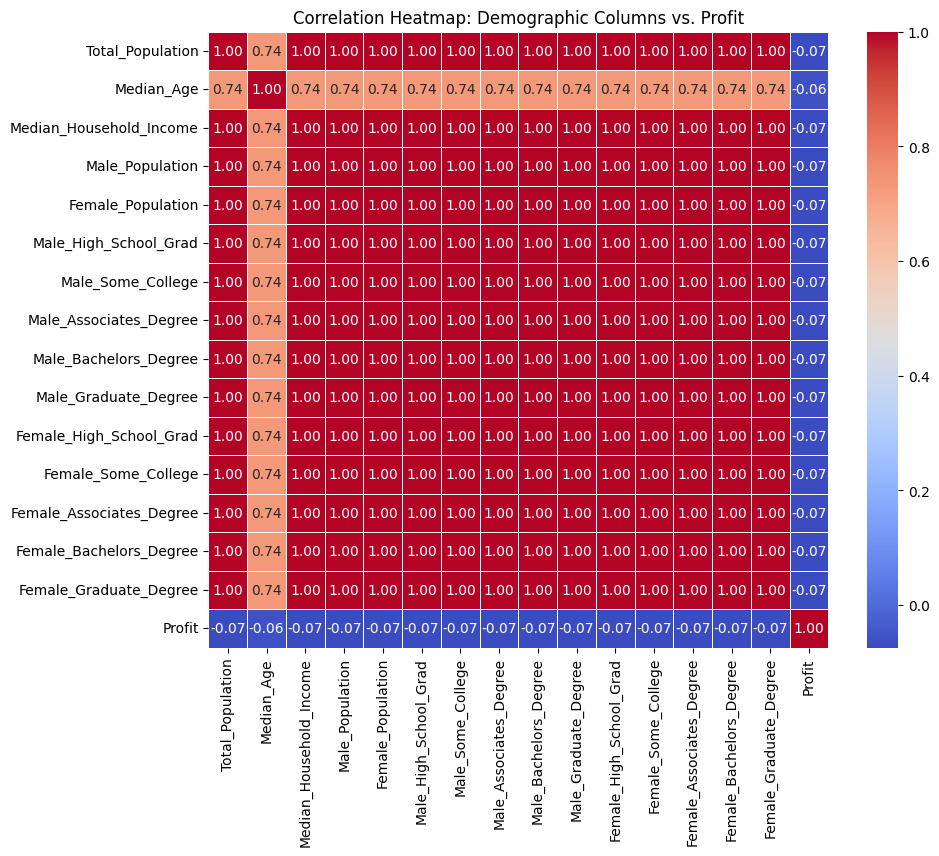

In [21]:
# Identify demographic columns and the target variable 'Profit'
# Ensure 'Profit' is treated as numeric, as it should be for regression
# Using the re-created census_df to identify demographic columns
demographic_cols = [col for col in merged_df.columns if col in census_df.columns and merged_df[col].dtype in ['float64', 'int64']]
analysis_cols = demographic_cols + ['Profit']

# Calculate the correlation matrix
# Drop rows with NaN in the selected columns before calculating correlation
correlation_matrix = merged_df[analysis_cols].dropna().corr()

# Display the correlation matrix
print("Correlation Matrix (Demographic Columns vs. Profit):")
display(correlation_matrix)

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap: Demographic Columns vs. Profit")
plt.show()

In [22]:
# Define the target variable
y_merged = merged_df['Profit']

# Define the features by dropping the target and identifier/unnecessary columns
# Exclude original target 'Profit', original 'Returned', and string/ID columns not used as features
columns_to_drop_for_features = ['Profit', 'Returned', 'Order_ID', 'Order_Date', 'Ship_Date', 'Customer_ID',
                                'Customer_Name', 'Product_ID', 'Product_Name', 'Order ID',
                                'Postal_Code_Str', 'Postal_Code_sales', 'Postal_Code_census', 'NAME'] # Include columns from both original and census data if they exist

# Drop columns that are not features or are identifiers/duplicates from the merge
# Use errors='ignore' in case some columns don't exist in the dataframe
X_merged = merged_df.drop(columns=columns_to_drop_for_features, errors='ignore')


# Display the first few rows of the features DataFrame and its info
print("Features DataFrame (X_merged) head:")
display(X_merged.head())
print("\nFeatures DataFrame (X_merged) info:")
X_merged.info()

Features DataFrame (X_merged) head:


,Row_ID,Ship_Mode,Segment,Country,City,State,Region,Category,Sub-Category,Sales,...,Male_High_School_Grad,Male_Some_College,Male_Associates_Degree,Male_Bachelors_Degree,Male_Graduate_Degree,Female_High_School_Grad,Female_Some_College,Female_Associates_Degree,Female_Bachelors_Degree,Female_Graduate_Degree
0,1,Second Class,Consumer,United States,Henderson,Kentucky,South,Furniture,Bookcases,261.9600,...,4800.0,3200.0,2560.0,3840.0,1600.0,5120.0,3520.0,2880.0,4160.0,1920.0
1,2,Second Class,Consumer,United States,Henderson,Kentucky,South,Furniture,Chairs,731.9400,...,4800.0,3200.0,2560.0,3840.0,1600.0,5120.0,3520.0,2880.0,4160.0,1920.0
2,3,Second Class,Corporate,United States,Los Angeles,California,West,Office Supplies,Labels,14.6200,...,5040.0,3360.0,2688.0,4032.0,1680.0,5376.0,3696.0,3024.0,4368.0,2016.0
3,4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,South,Furniture,Tables,957.5775,...,4665.0,3110.0,2488.0,3732.0,1555.0,4976.0,3421.0,2799.0,4043.0,1866.0
4,5,Standard Class,Consumer,United States,Fort Lauderdale,Florida,South,Office Supplies,Storage,22.3680,...,4665.0,3110.0,2488.0,3732.0,1555.0,4976.0,3421.0,2799.0,4043.0,1866.0



Features DataFrame (X_merged) info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Row_ID                    9994 non-null   int64  
 1   Ship_Mode                 9994 non-null   object 
 2   Segment                   9994 non-null   object 
 3   Country                   9994 non-null   object 
 4   City                      9994 non-null   object 
 5   State                     9994 non-null   object 
 6   Region                    9994 non-null   object 
 7   Category                  9994 non-null   object 
 8   Sub-Category              9994 non-null   object 
 9   Sales                     9994 non-null   float64
 10  Quantity                  9994 non-null   int64  
 11  Discount                  9994 non-null   float64
 12  Total_Population          3073 non-null   float64
 13  Median_Age                

In [23]:
# Identify categorical columns in the features DataFrame
categorical_cols_merged = X_merged.select_dtypes(include=['object', 'category']).columns.tolist()

# Apply one-hot encoding to the identified categorical columns
X_merged_encoded = pd.get_dummies(X_merged, columns=categorical_cols_merged, dummy_na=False)


# Display the first few rows of the encoded features DataFrame and its info
print("Encoded Features DataFrame (X_merged_encoded) head:")
display(X_merged_encoded.head())
print("\nEncoded Features DataFrame (X_merged_encoded) info:")
X_merged_encoded.info()

# Update X and y to use the merged and encoded data for subsequent steps
X = X_merged_encoded
y = y_merged

Encoded Features DataFrame (X_merged_encoded) head:


,Row_ID,Sales,Quantity,Discount,Total_Population,Median_Age,Median_Household_Income,Male_Population,Female_Population,Male_High_School_Grad,...,Sub-Category_Envelopes,Sub-Category_Fasteners,Sub-Category_Furnishings,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables
0,1,261.9600,2,0.00,32000.0,37.0,60000.0,15360.0,16640.0,4800.0,...,False,False,False,False,False,False,False,False,False,False
1,2,731.9400,3,0.00,32000.0,37.0,60000.0,15360.0,16640.0,4800.0,...,False,False,False,False,False,False,False,False,False,False
2,3,14.6200,2,0.00,33600.0,38.6,68000.0,16128.0,17472.0,5040.0,...,False,False,False,True,False,False,False,False,False,False
3,4,957.5775,5,0.45,31100.0,36.1,55500.0,14928.0,16172.0,4665.0,...,False,False,False,False,False,False,False,False,False,True
4,5,22.3680,2,0.20,31100.0,36.1,55500.0,14928.0,16172.0,4665.0,...,False,False,False,False,False,False,False,True,False,False



Encoded Features DataFrame (X_merged_encoded) info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Columns: 631 entries, Row_ID to Sub-Category_Tables
dtypes: bool(612), float64(17), int64(2)
memory usage: 7.3 MB


In [24]:
# Identify the columns with missing values that need imputation
# Based on the output of the previous cell, these are likely the demographic and interaction columns
columns_to_impute = ['Total_Population', 'Median_Age', 'Median_Household_Income', 'Male_Population', 'Female_Population',
                     'Male_High_School_Grad', 'Male_Some_College', 'Male_Associates_Degree', 'Male_Bachelors_Degree',
                     'Male_Graduate_Degree', 'Female_High_School_Grad', 'Female_Some_College', 'Female_Associates_Degree',
                     'Female_Bachelors_Degree', 'Female_Graduate_Degree']

# Instantiate the SimpleImputer with a median strategy
imputer = SimpleImputer(strategy='median')

# Apply imputation to the identified columns in merged_df
# Imputer works on NumPy arrays, so we select the columns and then reassign the imputed values back
merged_df[columns_to_impute] = imputer.fit_transform(merged_df[columns_to_impute])

# Verify that missing values have been imputed
print("Missing values in merged_df after imputation:")
print(merged_df[columns_to_impute].isnull().sum())

Missing values in merged_df after imputation:
Total_Population            0
Median_Age                  0
Median_Household_Income     0
Male_Population             0
Female_Population           0
Male_High_School_Grad       0
Male_Some_College           0
Male_Associates_Degree      0
Male_Bachelors_Degree       0
Male_Graduate_Degree        0
Female_High_School_Grad     0
Female_Some_College         0
Female_Associates_Degree    0
Female_Bachelors_Degree     0
Female_Graduate_Degree      0
dtype: int64


In [25]:
# Create the interaction term
# Handle potential NaN values by ensuring they propagate or filling them beforehand if desired
merged_df['Income_x_Sales'] = merged_df['Median_Household_Income'] * merged_df['Sales']

# Display the head of the merged_df to show the new column
print("Merged DataFrame with new 'Income_x_Sales' interaction term:")
display(merged_df[['Median_Household_Income', 'Sales', 'Income_x_Sales']].head())

# Check for missing values in the new column
print("\nMissing values in 'Income_x_Sales':")
print(merged_df['Income_x_Sales'].isnull().sum())

Merged DataFrame with new 'Income_x_Sales' interaction term:


,Median_Household_Income,Sales,Income_x_Sales
0,60000.0,261.9600,15717600.00
1,60000.0,731.9400,43916400.00
2,68000.0,14.6200,994160.00
3,55500.0,957.5775,53145551.25
4,55500.0,22.3680,1241424.00



Missing values in 'Income_x_Sales':
0


In [26]:
# Check for missing values in the merged_df
print("Missing values in merged_df:")
print(merged_df.isnull().sum())

Missing values in merged_df:
Row_ID                         0
Order_ID                       0
Order_Date                     0
Ship_Date                      0
Ship_Mode                      0
Customer_ID                    0
Customer_Name                  0
Segment                        0
Country                        0
City                           0
State                          0
Postal_Code_sales              0
Region                         0
Product_ID                     0
Category                       0
Sub-Category                   0
Product_Name                   0
Sales                          0
Quantity                       0
Discount                       0
Profit                         0
Returned                    9698
Order ID                    9698
Postal_Code_Str                0
NAME                        6921
Total_Population               0
Median_Age                     0
Median_Household_Income        0
Male_Population                0
Female_Populat

In [27]:
# Create a DataFrame to store the performance metrics
regression_results_merged_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'R2'])

# Re-iterate through each regression model to populate the DataFrame
for model in regression_models:
    model_name = type(model).__name__

    try:
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Append the results to the DataFrame
        new_row = pd.DataFrame({'Model': [model_name], 'MAE': [mae], 'MSE': [mse], 'R2': [r2]})
        regression_results_merged_df = pd.concat([regression_results_merged_df, new_row], ignore_index=True)

    except Exception as e:
        print(f"Could not get metrics for {model_name}: {e}")


# Sort the DataFrame by R-squared score in descending order
regression_results_merged_df = regression_results_merged_df.sort_values(by='R2', ascending=False)

# Display the performance comparison
print("\n=== Regression Model Performance Comparison (with Merged Data) ===")
display(regression_results_merged_df)

/tmp/ipython-input-1813470591.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_results_merged_df = pd.concat([regression_results_merged_df, new_row], ignore_index=True)
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



=== Regression Model Performance Comparison (with Merged Data) ===


,Model,MAE,MSE,R2
4,KNeighborsRegressor,32.061511,1.098612e+04,0.655809
6,RandomForestRegressor,25.085469,1.179303e+04,0.630528
9,HistGradientBoostingRegressor,27.178645,1.230589e+04,0.614461
13,MLPRegressor,42.488902,1.351444e+04,0.576597
10,BaggingRegressor,26.645279,1.380884e+04,0.567374
11,VotingRegressor,35.685240,1.491488e+04,0.532722
12,StackingRegressor,32.345988,1.536285e+04,0.518687
8,AdaBoostRegressor,64.033396,1.714388e+04,0.462888
7,GradientBoostingRegressor,30.321228,1.738838e+04,0.455228
2,Lasso,53.308935,1.901968e+04,0.404120


In [ ]:
# Identify the best performing model from the results with merged data
if 'regression_results_merged_df' in locals() and not regression_results_merged_df.empty:
    best_model_name_merged = regression_results_merged_df.iloc[0]['Model']
    print(f"The best performing model with merged data is: {best_model_name_merged}")

    # Find the best model object from the original list (assuming regression_models is available)
    best_model_merged = None
    for model in regression_models:
        if type(model).__name__ == best_model_name_merged:
            best_model_merged = model
            break

    if best_model_merged:
        # Calculate permutation importance on the test set (which contains merged data)
        print(f"\nCalculating permutation importance for {best_model_name_merged} on the test set (merged data)...")
        # Ensure the model is fitted to the merged training data
        best_model_merged.fit(X_train, y_train)

        perm_res_merged = permutation_importance(best_model_merged, X_test, y_test, n_repeats=30, random_state=RANDOM_STATE, n_jobs=-1, scoring='r2') # Use r2 as scoring

        # Create a pandas Series for permutation importances
        permutation_importances_merged = pd.Series(perm_res_merged.importances_mean, index=X_test.columns)

        # Sort permutation importances in descending order
        sorted_permutation_importances_merged = permutation_importances_merged.sort_values(ascending=False)

        # Display the top 20 most important features
        top_n = 20
        print(f"\nTop {top_n} most important features for {best_model_name_merged} (Permutation Importance on merged data):")
        display(sorted_permutation_importances_merged.head(top_n))

        # Briefly interpret the results
        print("\nInterpretation:")
        print(f"Based on permutation importance from the {best_model_name_merged} model trained on merged data, the features with the highest importance scores have the most significant impact on predicting 'Profit'. These features, listed above, are the ones that, when randomly shuffled, cause the largest decrease in the model's performance (measured by the R-squared score) on the test set.")

    else:
        print(f"Could not find the best performing model object: {best_model_name_merged}")

else:
    print("regression_results_merged_df not found or is empty. Please ensure models have been trained and evaluated on the merged data.")

In [ ]:
# Iterate through each regression model
for model in regression_models:
    model_name = type(model).__name__
    print(f"Training and evaluating {model_name}...")

    try:
        # Fit the model to the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Print the results
        print(f"{model_name} Metrics:")
        print(f"  Mean Absolute Error (MAE): {mae:.4f}")
        print(f"  Mean Squared Error (MSE): {mse:.4f}")
        print(f"  R-squared (R2): {r2:.4f}")
        print("-" * 30)

    except Exception as e:
        print(f"Error training or evaluating {model_name}: {e}")
        print("-" * 30)

In [ ]:
# Instantiate the Census API client
# Using the API key from a previous successful cell
#CENSUS_KEY = "18bff4ee2c749edcae4f6052cde2e47851ce4cc0"
#c = Census(CENSUS_KEY, year=2010)
os.environ['CENSUS_API_KEY'] = "18bff4ee2c749edcae4f6052cde2e47851ce4cc0"
c = Census(os.environ['CENSUS_API_KEY'], year=2010)

# Define the variables to fetch
census_variables = [
    'NAME',          # ZCTA name
    'B01001_001E',   # Total Population
    'B01002_001E',   # Median Age
    'B19013_001E',   # Median Household Income
    'B01001_002E',   # Male Population
    'B01001_026E',   # Female Population
    'B15002_003E',   # Male: High school graduate
    'B15002_004E',   # Male: Some college, no degree
    'B15002_005E',   # Male: Associate's degree
    'B15002_006E',   # Male: Bachelor's degree
    'B15002_007E',   # Male: Graduate or professional degree
    'B15002_018E',   # Female: High school graduate
    'B15002_019E',   # Female: Some college, no degree
    'B15002_020E',   # Female: Associate's degree
    'B15002_021E',   # Female: Bachelor's Degree
    'B15002_022E',   # Female: Graduate or professional degree
    'zip code tabulation area' # ZCTA code
]

# Fetch data for all ZCTAs in the US (using the 2021 ACS 5-year estimates)
# Note: This might take some time as there are many ZCTAs
print("Fetching Census data for all ZCTAs...")
try:
    census_data = c.acs5.get(census_variables, {'for': 'zip code tabulation area:*'})
except Exception as e:
    print(f"Error fetching Census data: {e}")
    census_data = None

# Convert the fetched data to a pandas DataFrame
if census_data:
    census_df = pd.DataFrame(census_data)

    # Rename columns for clarity
    census_df = census_df.rename(columns={
        'B01001_001E': 'Total_Population',
        'B01002_001E': 'Median_Age',
        'B19013_001E': 'Median_Household_Income',
        'B01001_002E': 'Male_Population',
        'B01001_026E': 'Female_Population',
        'B15002_003E': 'Male_High_School_Grad',
        'B15002_004E': 'Male_Some_College',
        'B15002_005E': 'Male_Associates_Degree',
        'B15002_006E': 'Male_Bachelors_Degree',
        'B15002_007E': 'Male_Graduate_Degree',
        'B15002_018E': 'Female_High_School_Grad',
        'B15002_019E': 'Female_Some_College',
        'B15002_020E': 'Female_Associates_Degree',
        'B15002_021E': 'Female_Bachelors_Degree',
        'B15002_022E': 'Female_Graduate_Degree',
        'zip code tabulation area': 'Postal_Code_Str' # Rename ZCTA code column
    })

    # Convert Postal_Code in census_df to integer for merging
    # Handle potential errors during conversion if 'zip code tabulation area' contains non-integer values
    try:
        census_df['Postal_Code'] = pd.to_numeric(census_df['Postal_Code_Str'], errors='coerce').astype('Int64') # Use nullable integer type for potential NaNs
    except ValueError as e:
         print(f"Error converting 'zip code tabulation area' to integer: {e}")
         print("Some ZCTA codes might not be purely numeric. Proceeding with string merge.")
         census_df['Postal_Code'] = None # Set to None if conversion fails


    print("\nCensus Data Preview:")
    display(census_df.head())
    print("\nCensus Data Info:")
    census_df.info()
else:
    print("Failed to fetch Census data.")

In [ ]:
# Check if census_df is defined
if 'census_df' in locals():
    print("census_df is available.")
    print("\nCensus Data Preview:")
    display(census_df.head())
    print("\nCensus Data Info:")
    census_df.info()
else:
    print("census_df is not available.")

In [ ]:
# Assuming mae_mse_comparison is available and contains 'Model', 'MAE_Change', and 'MSE_Change' columns
if 'mae_mse_comparison' in locals():
    # Sort by MAE Change (most negative change first) to highlight models with improved MAE
    mae_mse_comparison_sorted = mae_mse_comparison.sort_values(by='MAE_Change', ascending=True).reset_index(drop=True)

    # Select the top N models to plot (e.g., top 10 or all if less than 10)
    top_n_plot = min(len(mae_mse_comparison_sorted), 10) # Plot top 10 or fewer if available
    plot_data = mae_mse_comparison_sorted.head(top_n_plot)

    # Reshape data for plotting
    plot_data_melted = plot_data.melt(id_vars='Model', value_vars=['MAE_Change', 'MSE_Change'], var_name='Metric', value_name='Change')


    plt.figure(figsize=(12, 8))
    sns.barplot(x='Change', y='Model', hue='Metric', data=plot_data_melted, palette='viridis')
    plt.xlabel("Change in Error (After PCA - Before PCA)")
    plt.ylabel("Model")
    plt.title(f"Change in MAE and MSE for Top {top_n_plot} Models After PCA")
    plt.grid(axis='x', linestyle='--')
    plt.show()

else:
    print("mae_mse_comparison DataFrame not found. Please ensure the MAE and MSE comparison has been generated.")

In [ ]:
# Assuming mae_mse_comparison is available
if 'mae_mse_comparison' in locals():
    # Sort by MAE_Change in ascending order to find the largest improvements (most negative changes)
    top_mae_improvement = mae_mse_comparison.sort_values(by='MAE_Change', ascending=True).head(5)

    print("Top 5 Models with Largest MAE Improvement After PCA:")
    display(top_mae_improvement)
else:
    print("mae_mse_comparison DataFrame not found. Please ensure the MAE and MSE comparison has been generated.")

In [ ]:
# Assuming comparison_df is available
if 'comparison_df' in locals():
    # Select relevant columns for MAE and MSE comparison
    mae_mse_comparison = comparison_df[['Model', 'MAE_BeforePCA', 'MSE_BeforePCA', 'MAE_AfterPCA', 'MSE_AfterPCA']].copy()

    # Calculate the change in MAE and MSE
    mae_mse_comparison['MAE_Change'] = mae_mse_comparison['MAE_AfterPCA'] - mae_mse_comparison['MAE_BeforePCA']
    mae_mse_comparison['MSE_Change'] = mae_mse_comparison['MSE_AfterPCA'] - mae_mse_comparison['MSE_BeforePCA']

    # Display the comparison table, sorted by MAE change (most negative change first)
    print("MAE and MSE Comparison (Before vs After PCA):")
    display(mae_mse_comparison.sort_values(by='MAE_Change', ascending=True))

    # Provide a brief interpretation
    print("\nInterpretation:")
    print("The 'MAE_Change' column shows the change in Mean Absolute Error (After PCA - Before PCA). A negative value indicates improved performance (lower error).")
    print("The 'MSE_Change' column shows the change in Mean Squared Error (After PCA - Before PCA). A negative value indicates improved performance (lower error).")
    print("Models with larger negative values in 'MAE_Change' and 'MSE_Change' benefited the most from PCA in terms of reducing these errors.")

else:
    print("comparison_df not found. Please ensure the comparison DataFrame has been generated.")

In [ ]:
# Assuming comparison_df is available
if 'comparison_df' in locals():
    print("Top models by R-squared BEFORE PCA:")
    display(comparison_df.sort_values(by='R2_BeforePCA', ascending=False).head())

    print("\nTop models by R-squared AFTER PCA:")
    display(comparison_df.sort_values(by='R2_AfterPCA', ascending=False).head())

    print("\nTop models by R-squared CHANGE (most improved after PCA):")
    display(comparison_df.sort_values(by='R2_Change', ascending=False).head())

    # Provide a brief interpretation
    print("\nInterpretation:")
    print("By comparing these tables, you can see which models were the top performers initially (before PCA), which ones are the top performers now (after PCA), and which models benefited most from the dimensionality reduction based on the change in R-squared.")
else:
    print("comparison_df not found. Please ensure the comparison DataFrame has been generated.")

In [ ]:
# Assuming comparison_df is available and contains 'Model' and 'R2_Change' columns
if 'comparison_df' in locals():
    # Sort the comparison_df by R2_Change for better visualization
    comparison_df_sorted = comparison_df.sort_values(by='R2_Change', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='R2_Change', y='Model', data=comparison_df_sorted, palette='viridis')
    plt.xlabel("R2 Change (After PCA - Before PCA)")
    plt.ylabel("Model")
    plt.title("Impact of PCA on Regression Model R-squared")
    plt.grid(axis='x', linestyle='--')
    plt.show()
else:
    print("comparison_df not found. Please ensure the comparison DataFrame has been generated.")

In [ ]:
# Identify the demographic columns in the merged_df
# Assuming demographic columns are those that came from census_df and are numeric
demographic_cols = [col for col in merged_df.columns if col in census_df.columns and merged_df[col].dtype in ['float64', 'int64']]

# Display descriptive statistics for the demographic columns
if demographic_cols:
    print("Descriptive statistics for demographic columns:")
    display(merged_df[demographic_cols].describe())
else:
    print("No numeric demographic columns found in merged_df.")

In [ ]:
# Check the data type and look at some unique postal codes
print("Data type of 'Postal_Code':", super_df['Postal_Code'].dtype)
print("\nFirst 20 unique Postal Codes:")
print(super_df['Postal_Code'].unique()[:20])

# Check the range of postal codes to see if they appear to be US postal codes
print("\nMin Postal Code:", super_df['Postal_Code'].min())
print("Max Postal Code:", super_df['Postal_Code'].max())

Descriptive statistics for 'Discount':


,Discount
count,9994.000000
mean,0.156203
std,0.206452
min,0.000000
25%,0.000000
50%,0.200000
75%,0.200000
max,0.800000


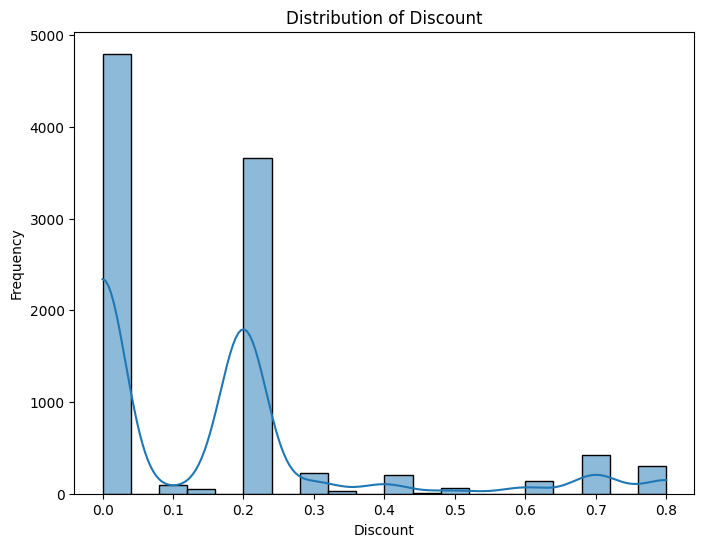

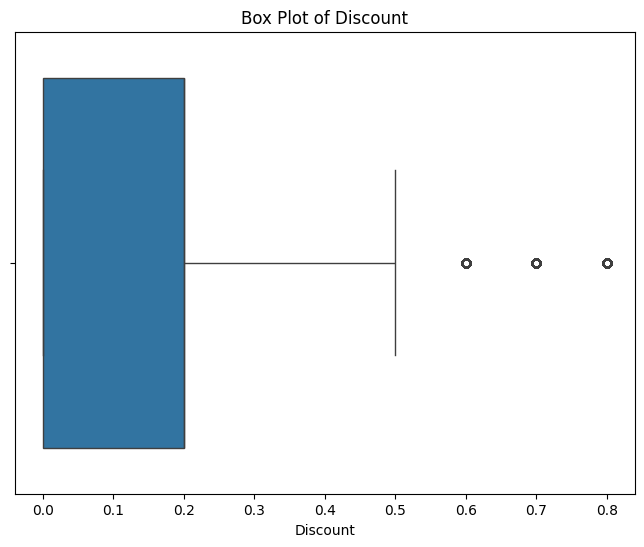

In [39]:
# Analyze the 'Discount' column
print("Descriptive statistics for 'Discount':")
display(super_df['Discount'].describe())

# Visualize the distribution of 'Discount'
plt.figure(figsize=(8, 6))
sns.histplot(super_df['Discount'], bins=20, kde=True)
plt.xlabel("Discount")
plt.ylabel("Frequency")
plt.title("Distribution of Discount")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x=super_df['Discount'])
plt.xlabel("Discount")
plt.title("Box Plot of Discount")
plt.show()

In [ ]:
# Display the top 3 rows of the regression_results_df
display(regression_results_df.head(3))

In [ ]:
# Assuming sorted_permutation_importances was generated in the previous cell
if 'sorted_permutation_importances' in locals():
    plt.figure(figsize=(12, 8))
    sns.barplot(x=sorted_permutation_importances.values, y=sorted_permutation_importances.index)
    plt.xlabel("Permutation Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importances for HistGradientBoostingRegressor (Permutation Importance)")
    plt.tight_layout()
    plt.show()
else:
    print("Permutation importances not found. Please run the previous cell to calculate them.")

In [42]:
# Identify the best performing model from the sorted results (assuming regression_results_df is available)
best_model_name = regression_results_df.iloc[0]['Model']

# Find the best model object from the original list (assuming regression_models is available)
best_model = None
for model in regression_models:
    if type(model).__name__ == best_model_name:
        best_model = model
        break

if best_model:
    # Calculate permutation importance on the test set
    print(f"\nCalculating permutation importance for {best_model_name} on the test set...")
    perm_res = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=RANDOM_STATE, n_jobs=-1)

    # Create a pandas Series for permutation importances
    permutation_importances = pd.Series(perm_res.importances_mean, index=X_test.columns)

    # Sort permutation importances in descending order
    sorted_permutation_importances = permutation_importances.sort_values(ascending=False)

    # Display the top 20 most important features
    top_n = 20
    print(f"\nTop {top_n} most important features for {best_model_name} (Permutation Importance):")
    display(sorted_permutation_importances.head(top_n))

    # Briefly interpret the results
    print("\nInterpretation:")
    print(f"Based on permutation importance from the {best_model_name} model, the features with the highest importance scores have the most significant impact on predicting 'Profit'. These features, listed above, are the ones that, when randomly shuffled, cause the largest decrease in the model's performance (measured by the R-squared score) on the test set.")

else:
    print(f"Could not find the best performing model: {best_model_name}")


Calculating permutation importance for KNeighborsRegressor on the test set...

Top 20 most important features for KNeighborsRegressor (Permutation Importance):


,0
Sales,1.262663
Discount,0.877838
Postal_Code,0.023854
Quantity,-0.006985
Row_ID,-0.078480



Interpretation:
Based on permutation importance from the KNeighborsRegressor model, the features with the highest importance scores have the most significant impact on predicting 'Profit'. These features, listed above, are the ones that, when randomly shuffled, cause the largest decrease in the model's performance (measured by the R-squared score) on the test set.


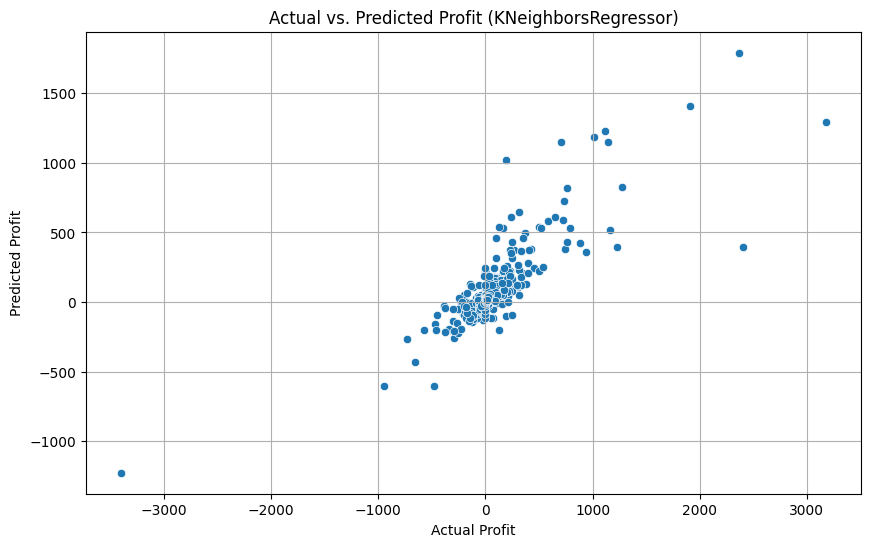

In [43]:
# Identify the best performing model name (assuming regression_results_df is available)
best_model_name = regression_results_df.iloc[0]['Model']

# Find the best model object from the original list (assuming regression_models is available)
best_model = None
for model in regression_models:
    if type(model).__name__ == best_model_name:
        best_model = model
        break

if best_model:
    # Make predictions on the test set using the best model
    y_pred_best_model = best_model.predict(X_test)

    # Create a scatter plot of actual vs. predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred_best_model)
    plt.xlabel("Actual Profit")
    plt.ylabel("Predicted Profit")
    plt.title(f"Actual vs. Predicted Profit ({best_model_name})")
    plt.grid(True)
    plt.show()
else:
    print(f"Could not find the best performing model: {best_model_name}")

In [44]:
display(regression_results_df)

,Model,MAE,MSE,R2
4,KNeighborsRegressor,32.061511,1.098612e+04,0.655809
6,RandomForestRegressor,25.085469,1.179303e+04,0.630528
9,HistGradientBoostingRegressor,27.178645,1.230589e+04,0.614461
13,MLPRegressor,42.488902,1.351444e+04,0.576597
10,BaggingRegressor,26.645279,1.380884e+04,0.567374
11,VotingRegressor,35.685240,1.491488e+04,0.532722
12,StackingRegressor,32.345988,1.536285e+04,0.518687
8,AdaBoostRegressor,64.033396,1.714388e+04,0.462888
7,GradientBoostingRegressor,30.321228,1.738838e+04,0.455228
2,Lasso,53.308935,1.901968e+04,0.404120


In [45]:
# Filter the report to show columns recommended as 'Keep (Continuous)'
regression_candidates = report[report['Recommendation'] == 'Keep (Continuous)']

# Display the filtered report
print("Columns recommended for Regression:")
display(regression_candidates)

Columns recommended for Regression:


,Column,Data Type,Unique Values,Recommendation
0,Row_ID,int64,9994,Keep (Continuous)
11,Postal_Code,int64,631,Keep (Continuous)
17,Sales,float64,5825,Keep (Continuous)
18,Quantity,int64,14,Keep (Continuous)
19,Discount,float64,12,Keep (Continuous)
20,Profit,float64,7287,Keep (Continuous)


In [46]:
# Replace with your actual Census API key
c = Census("18bff4ee2c749edcae4f6052cde2e47851ce4cc0")

# Example: Get total population, median age, and median household income for Miami-Dade County, FL
# from the 2021 5-year American Community Survey (ACS) estimates.
# FIPS code for Florida is 12, FIPS code for Miami-Dade County is 086.
# See https://api.census.gov/data/2021/acs/acs5/variables.html for variable codes.
# Total Population: B01001_001E
# Median Age: B01002_001E
# Median Household Income: B19013_001E

miami_dade_data = c.acs5.get(('NAME', 'B01001_001E', 'B01002_001E', 'B19013_001E'),
                          {'for': 'county:086',
                           'in': 'state:12'})

# The result is a list of dictionaries, usually with one dictionary for a specific county request.
if miami_dade_data:
    data = miami_dade_data[0]
    print(f"Demographic Data for {data['NAME']}:")
    print(f"  Total Population: {data['B01001_001E']}")
    print(f"  Median Age: {data['B01002_001E']}")
    print(f"  Median Household Income: {data['B19013_001E']}")
else:
    print("Could not retrieve data for Miami-Dade County.")

# To get data for gender and education level, you would need to find the specific variable codes
# in the Census API documentation (link provided above) and add them to the get() call.
# For example, for gender you might look at variables starting with B01001.
# For education level, you might look at variables starting with B15002.

Demographic Data for Miami-Dade County, Florida:
  Total Population: 2685296.0
  Median Age: 40.8
  Median Household Income: 68694.0


In [47]:
print(census_df.columns)

Index(['NAME', 'Total_Population', 'Median_Age', 'Median_Household_Income',
       'Male_Population', 'Female_Population', 'Male_High_School_Grad',
       'Male_Some_College', 'Male_Associates_Degree', 'Male_Bachelors_Degree',
       'Male_Graduate_Degree', 'Female_High_School_Grad',
       'Female_Some_College', 'Female_Associates_Degree',
       'Female_Bachelors_Degree', 'Female_Graduate_Degree', 'Postal_Code_Str',
       'Postal_Code'],
      dtype='object')


In [48]:
# Create a DataFrame from the Census data
census_df = pd.DataFrame(miami_dade_data)

# Display the DataFrame
print("Census DataFrame:")
display(census_df)

Census DataFrame:


,NAME,B01001_001E,B01002_001E,B19013_001E,state,county
0,"Miami-Dade County, Florida",2685296.0,40.8,68694.0,12,086


In [49]:
# Define base classifiers for Voting and Stacking
base_classifiers = [
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('svc', SVC(probability=True))  # Probability required for AUC-ROC
]

In [50]:
# Combine all classifiers, comment out those you don't want to use
classifiers = [
    LogisticRegression(), RidgeClassifier(), SGDClassifier(), Perceptron(),
    SVC(probability=True), KNeighborsClassifier(), RadiusNeighborsClassifier(),
    GaussianProcessClassifier(), DecisionTreeClassifier(), RandomForestClassifier(),
    GradientBoostingClassifier(), AdaBoostClassifier(), HistGradientBoostingClassifier(),
    BaggingClassifier(),
    VotingClassifier(estimators=base_classifiers, voting='soft'),  # Voting Classifier with base classifiers
    StackingClassifier(estimators=base_classifiers),  # Stacking Classifier with base classifiers
    MLPClassifier(),
    GaussianNB(),
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), lgb.LGBMClassifier(), CatBoostClassifier(verbose=0)
]

In [ ]:
# DataFrame to store ROC-AUC scores
results_df = pd.DataFrame(columns=['Model', 'ROC-AUC Score'])

# Iterate over models and evaluate performance
for model in classifiers:
    try:
        start = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start

        start = time.time()
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        predict_time = time.time() - start

        # Collect performance metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else None

        # Print performance metrics
        print(model)
        print(f"\tTraining time: {train_time:.3f}s")
        print(f"\tPrediction time: {predict_time:.3f}s")
        print(f"\tAccuracy: {accuracy:.3f}")
        print(f"\tPrecision: {precision:.3f}")
        print(f"\tRecall: {recall:.3f}")
        print(f"\tF1 Score: {f1:.3f}")
        if roc_auc is not None:
            print(f"\tROC-AUC Score: {roc_auc:.3f}")
        print()

        # Append the ROC-AUC score to the results dataframe (if available)
        if roc_auc is not None:
            row = pd.DataFrame({'Model': [type(model).__name__], 'ROC-AUC Score': [roc_auc]})
            results_df = pd.concat([results_df, row], ignore_index=True)

        # Classification report and confusion matrix
        print(f"Classification Report for {type(model).__name__}:\n")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
        plt.title(f'Confusion Matrix for {type(model).__name__}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    except Exception as e:
        print(f"Model {model} failed: {e}")
        print()

Model LogisticRegression() failed: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

Model RidgeClassifier() failed: Unknown label type: (array([ 27.882 ,  18.5391, -44.196 , ...,   6.2208,  43.736 ,  -7.7247]),)

Model SGDClassifier() failed: Unknown label type: (array([-6599.978 , -3839.9904, -3701.8928, ...,  5039.9856,  6719.9808,
        8399.976 ]),)

Model Perceptron() failed: Unknown label type: (array([-6599.978 , -3839.9904, -3701.8928, ...,  5039.9856,  6719.9808,
        8399.976 ]),)

Model SVC(probability=True) failed: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

Model KNeighborsClassifier() failed: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

Model RadiusNei

In [ ]:
# Sort the DataFrame by ROC-AUC score
results_df = results_df.sort_values(by='ROC-AUC Score', ascending=False)

# Display the sorted ROC-AUC scores
print(results_df)

# Plot a bar chart for ROC-AUC scores
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['ROC-AUC Score'], color='skyblue')
plt.xlabel('ROC-AUC Score')
plt.title('ROC-AUC Scores of Different Classifiers')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Basic column typing: numeric vs categorical (treat small-unique numerics as categorical)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
# Move numeric cols with small cardinality to categorical
numeric_small = [c for c in numeric_cols if X[c].nunique() <= 8]
for c in numeric_small:
    numeric_cols.remove(c)
    if c not in categorical_cols:
        categorical_cols.append(c)

In [ ]:
print(f"Numeric cols ({len(numeric_cols)}):", numeric_cols)
print(f"Categorical cols ({len(categorical_cols)}):", categorical_cols)

In [ ]:
# Ensure categorical columns are strings (safe for encoders)
for c in categorical_cols:
    X[c] = X[c].astype(str)

In [ ]:
# =========================
# Numeric correlation with target (Spearman - robust to nonlinearity)
# =========================

num_corr = {}
for c in numeric_cols:
    # drop na pairs
    valid = X[[c]].join(y).dropna()
    if valid.shape[0] < 3:
        num_corr[c] = 0.0
    else:
        coef, _ = spearmanr(valid[c], valid[target_col])
        num_corr[c] = abs(coef) if not np.isnan(coef) else 0.0

num_corr_series = pd.Series(num_corr).sort_values(ascending=False)

In [ ]:
# =========================
# Mutual Information (all features vs target)
# =========================
# For mutual_info_classif we need numeric arrays. We'll encode categoricals using OrdinalEncoder temporarily.
X_mi = X.copy()
if categorical_cols:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_mi[categorical_cols] = oe.fit_transform(X_mi[categorical_cols])


In [ ]:
# Impute missing numeric columns with median and categorical with a constant encoded value
imputer = SimpleImputer(strategy='median')
X_mi[numeric_cols] = imputer.fit_transform(X_mi[numeric_cols])

In [ ]:
# mutual_info_classif expects finite values
mi = mutual_info_classif(X_mi.fillna(-999), y, discrete_features=[c in categorical_cols for c in X_mi.columns], random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=X_mi.columns).sort_values(ascending=False)

In [ ]:
# =========================
# Univariate ROC AUC (single-feature CV using a simple pipeline)
# =========================
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
univar_scores = {}

In [ ]:
# Helper to build single-feature pipeline
def single_feature_pipeline(col):
    if col in numeric_cols:
        # numeric pipeline: impute->scale->logistic
        pipe = Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ])
    else:
        # categorical pipeline: impute -> OneHot (single col) -> passthrough
        # We'll use OrdinalEncoder for speed for single-feature logistic (keeps dimensionality 1)
        pipe = Pipeline([
            ('impute', SimpleImputer(strategy='constant', fill_value='MISSING')),
            ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ])
    return pipe

In [ ]:
clf = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)
scorer = 'roc_auc'

In [ ]:
for col in X.columns:
    X_col = X[[col]].copy()
    pre = single_feature_pipeline(col)
    # create a pipeline that preprocesses the single column then fits logistic
    full_pipe = Pipeline([
        ('pre', ColumnTransformer([(col, pre, [col])], remainder='drop')),
        ('clf', clf)
    ])
    try:
        scores = cross_val_score(full_pipe, X_col, y, cv=skf, scoring=scorer, n_jobs=1)
        univar_scores[col] = np.nanmean(scores)
    except Exception as e:
        # fallback: skip if something fails
        univar_scores[col] = np.nan

univar_series = pd.Series(univar_scores).sort_values(ascending=False)

In [ ]:
# =========================
# Permutation importance from a RandomForest trained on all features
# (use simple preprocessing: ordinal-encode categoricals, median-impute numerics)
# =========================
# Build a simple preprocessing for the full model
from sklearn.pipeline import make_pipeline

In [ ]:
# Prepare X_full for the RF (impute numeric, ordinal-encode categorical)
X_full = X.copy()
# Impute numerics
if numeric_cols:
    X_full[numeric_cols] = SimpleImputer(strategy='median').fit_transform(X_full[numeric_cols])
# Encode categoricals with OrdinalEncoder
if categorical_cols:
    oe_full = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_full[categorical_cols] = oe_full.fit_transform(X_full[categorical_cols])

rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_full, y)

perm_res = permutation_importance(rf, X_full, y, n_repeats=30, random_state=RANDOM_STATE, n_jobs=-1, scoring='roc_auc')
perm_series = pd.Series(perm_res.importances_mean, index=X_full.columns).sort_values(ascending=False)

In [ ]:
top_corr = num_corr_series.head(TOP_K)
top_mi = mi_series.head(TOP_K)
top_univar = univar_series.head(TOP_K)
top_perm = perm_series.head(TOP_K)

In [ ]:
# Print succinct output to console
print("\n=== Top features by Spearman correlation (numeric) ===")
print(top_corr.to_string())
print("\n=== Top features by Mutual Information ===")
print(top_mi.head(TOP_K).to_string())
print("\n=== Top features by Univariate CV ROC AUC ===")
print(top_univar.head(TOP_K).to_string())
print("\n=== Top features by Permutation Importance (mean) ===")
print(top_perm.head(TOP_K).to_string())

In [ ]:
print(miami_dade_data)

In [ ]:
if miami_dade_data:
    data = miami_dade_data[0]
    print("Keys and Values in Census Data:")
    for key, value in data.items():
        print(f"  {key}: {value}")
    print("\nGeographical level: County")
    print("Variables included: NAME, Total Population (B01001_001E), Median Age (B01002_001E), Median Household Income (B19013_001E), state FIPS code, county FIPS code.")
else:
    print("No Census data available to analyze.")

In [ ]:
# Display the comparison_df DataFrame
print("Performance Comparison (Before vs After PCA):")
display(comparison_df.sort_values(by='R2_Change', ascending=False))

# Display the mae_mse_comparison DataFrame
print("\nMAE and MSE Comparison (Before vs After PCA):")
display(mae_mse_comparison.sort_values(by='MAE_Change', ascending=True))